In [101]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-01-22'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

FN_MC = f'{DATA_DIR}/processed/mc_rdf_low_met.root'
FN_R3 = f'{DATA_DIR}/processed/r3_rdf_low_met.root'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

CTAU = 1000
# CTAUS = np.round(np.logspace(2, 4, 10), 0)
# CTAUS = np.round(np.logspace(1, 7, 55), 0)
CTAUS = np.round(np.logspace(1, 5, 30), 0)
if CTAU not in CTAUS:
    CTAUS = np.append(CTAUS, CTAU)
    CTAUS = np.sort(CTAUS)

# **** #

MIN_MET, MAX_MET = 10, 200
MIN_DPHI, MAX_DPHI = 0.4+0.1, PI-0.1
# MIN_DTSIZE, MAX_DTSIZE = 50+50, 200
MIN_DTSIZE, MAX_DTSIZE = 50+10, 200

# METS = np.arange(MIN_MET, MAX_MET+10, 10)
# DPHIS = np.arange(MIN_DTSIZE, MAX_DPHI+0.1, 0.1)
# DTSIZES = np.arange(MIN_DPHI, MAX_DTSIZE+10, 10)
# METS = np.arange(MIN_MET, MAX_MET+1, 1)
DPHIS = np.arange(MIN_DPHI, MAX_DPHI+0.1, 0.05)
DTSIZES = np.arange(MIN_DTSIZE, MAX_DTSIZE+1, 1)
# METS = np.array([10, 15, 20, 25, 50, 75, 100, 125, 150, 175])
METS = np.array([75, 150])

# **************** #

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
rdfs = {
    # 'mc_raw' : rt.RDataFrame('MuonSystem', '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'),
    # 'r3_raw' : rt.RDataFrame('MuonSystem_HLT569', '/home/psimmerl/mds_analysis/data/processed/r3_hlt569.root'),
    'mc' : RDataFrame('MuonSystem_flat', FN_MC).Filter('met < 200'),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3).Filter('met < 200'),
}

print('Events Read:')
for key, rdf in rdfs.items():
    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')
print('')

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_rdf_low_met.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_rdf_low_met.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-01-22'
Events Read:
  mc = 1,490 (900.09)
  r3 = 146 (146.00)



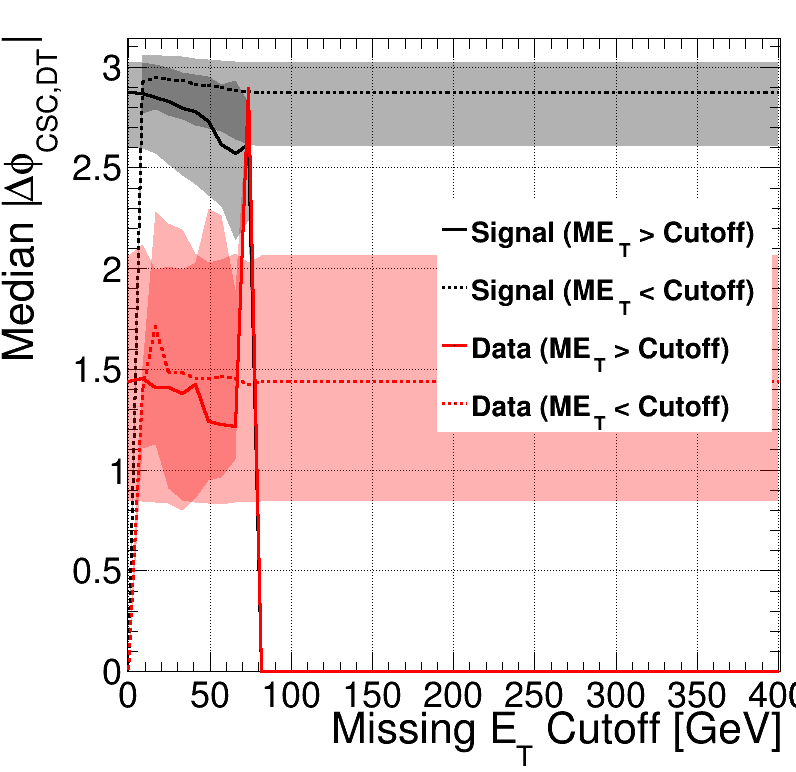

In [102]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.55, 0.44, 0.97, 0.74)
legend.SetBorderSize(0)
# legend.SetFillColorAlpha(rt.kBlack, 0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

mets = np.linspace(0,400,50)
# dphiA_mc = np.array([m.GetValue() for m in [rdfs['mc'].Filter(f'met > {met}').Mean('tag_dPhi') for met in mets]])
# dphiA_r3 = np.array([m.GetValue() for m in [rdfs['r3'].Filter(f'met > {met}').Mean('tag_dPhi') for met in mets]])
# dphiB_mc = np.array([m.GetValue() for m in [rdfs['mc'].Filter(f'met < {met}').Mean('tag_dPhi') for met in mets]])
# dphiB_r3 = np.array([m.GetValue() for m in [rdfs['r3'].Filter(f'met < {met}').Mean('tag_dPhi') for met in mets]])
dphiA_mc = [rdfs['mc'].Filter(f'met > {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]
dphiA_r3 = [rdfs['r3'].Filter(f'met > {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]
dphiB_mc = [rdfs['mc'].Filter(f'met < {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]
dphiB_r3 = [rdfs['r3'].Filter(f'met < {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]

# **** #
values, ylabel = [dphiA_mc,dphiB_mc,dphiA_r3,dphiB_r3], 'Median |#Delta#phi_{CSC,DT}|'#'Average |#Delta#phi|'

xlabel = 'Missing E_{T} Cutoff [GeV]'
names = ['Signal (ME_{T} > Cutoff)', 'Signal (ME_{T} < Cutoff)', 'Data (ME_{T} > Cutoff)', 'Data (ME_{T} < Cutoff)']
hmin, hmax = 0, PI
for igr, val in enumerate(values):
    if 'median' in ylabel.lower():
        yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    elif 'mean' in ylabel.lower():
        yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphAsymmErrors(len(mets),mets,yy[:,0]*1,mets*0,mets*0,yy[:,1]*1,yy[:,2]*1)
    gr.GetXaxis().SetLimits(np.min(mets)-1, np.max(mets)+1)
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

legend.Draw()
canvas.Draw()


In [103]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.17, 0.72, 0.62, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'tag_dPhi'

txy_label = ';|#Delta#phi_{CSC,DT}|;fraction of events'

form =(txy_label,32,0,PI)
# **** #

h1 = rdfs['mc'].Histo1D(('All Signal Events',*form),xv,).GetValue()
h2 = rdfs['mc'].Filter(f'met<75').Histo1D(('ME_{T} < 75 GeV',*form),xv).GetValue()
h3 = rdfs['mc'].Filter(f'met>75').Histo1D(('ME_{T} > 75 GeV',*form),xv).GetValue()
h4 = rdfs['mc'].Filter(f'met<150').Histo1D(('ME_{T} < 150 GeV',*form),xv).GetValue()
h5 = rdfs['mc'].Filter(f'met>150').Histo1D(('ME_{T} > 150 GeV',*form),xv).GetValue()

hhs = [h1,h2,h3,h4,h5]
# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    if hmax < 1:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')


legend.Draw()
canvas.Draw()


ZeroDivisionError: float division by zero

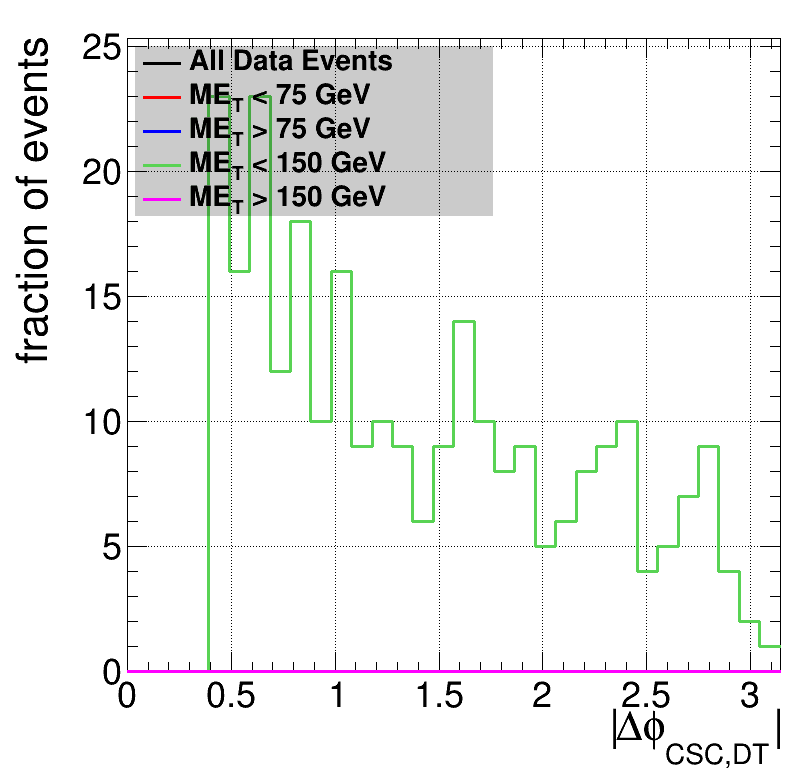

In [ ]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.17, 0.72, 0.62, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'tag_dPhi'

txy_label = ';|#Delta#phi_{CSC,DT}|;fraction of events'

form =(txy_label,32,0,PI)
# **** #

h1 = rdfs['r3'].Histo1D(('All Data Events',*form),xv,).GetValue()
h2 = rdfs['r3'].Filter(f'met<75').Histo1D(('ME_{T} < 75 GeV',*form),xv).GetValue()
h3 = rdfs['r3'].Filter(f'met>75').Histo1D(('ME_{T} > 75 GeV',*form),xv).GetValue()
h4 = rdfs['r3'].Filter(f'met<150').Histo1D(('ME_{T} < 150 GeV',*form),xv).GetValue()
h5 = rdfs['r3'].Filter(f'met>150').Histo1D(('ME_{T} > 150 GeV',*form),xv).GetValue()

hhs = [h1,h2,h3,h4,h5]
hmax = max([h.GetMaximum() for h in hhs])
# hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    if hmax < 1:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')


legend.Draw()
canvas.Draw()


In [104]:
# canvas = TCanvas('','',800,800)
# canvas.SetGrid()
# canvas.SetLogy()

# # legend = TLegend(0.17, 0.72, 0.62, 0.94)
# legend = TLegend(0.57, 0.72, 0.97, 0.94)
# legend.SetBorderSize(0)
# legend.SetFillColorAlpha(rt.kBlack, 0.2)
# legend.SetTextSize(0.04)
# legend.SetMargin(0.15)

# xv = 'met'

# txy_label = ';Missing E_{T} [GeV];count'

# form =(txy_label,20,0,200)
# # **** #

# h1 = rdfs['mc'].Histo1D(('Signal (after cuts)',*form),xv).GetValue()
# h2 = rdfs['r3'].Histo1D(('Data (after cuts)',*form),xv).GetValue()
# h3 = rdfs['mc_raw'].Histo1D(('Signal (no cuts)',*form),xv).GetValue()
# h4 = rdfs['r3_raw'].Histo1D(('Data (HLT only)',*form),xv).GetValue()
# # h2 = rdfs['mc'].Filter(f'met<75').Histo1D(('ME_{T} < 75 GeV',*form),xv).GetValue()
# # h3 = rdfs['mc'].Filter(f'met>75').Histo1D(('ME_{T} > 75 GeV',*form),xv).GetValue()
# hhs = [h1,h2,h3,h4]
# hmax = max([h.GetMaximum() for h in hhs])
# # hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
# for ih, hh in enumerate(hhs):
#     if hmax < 1:
#         hh.Scale(1/hh.Integral())
#     # hh.SetMinimum(0)
#     hh.SetMaximum(hmax*1.1)
#     hh.SetLineColor(SCL[ih])
#     hh.SetLineWidth(3)
#     hh.Draw('hist same')
#     legend.AddEntry(hh, hh.GetName(), 'L')


# legend.Draw()
# canvas.Draw()

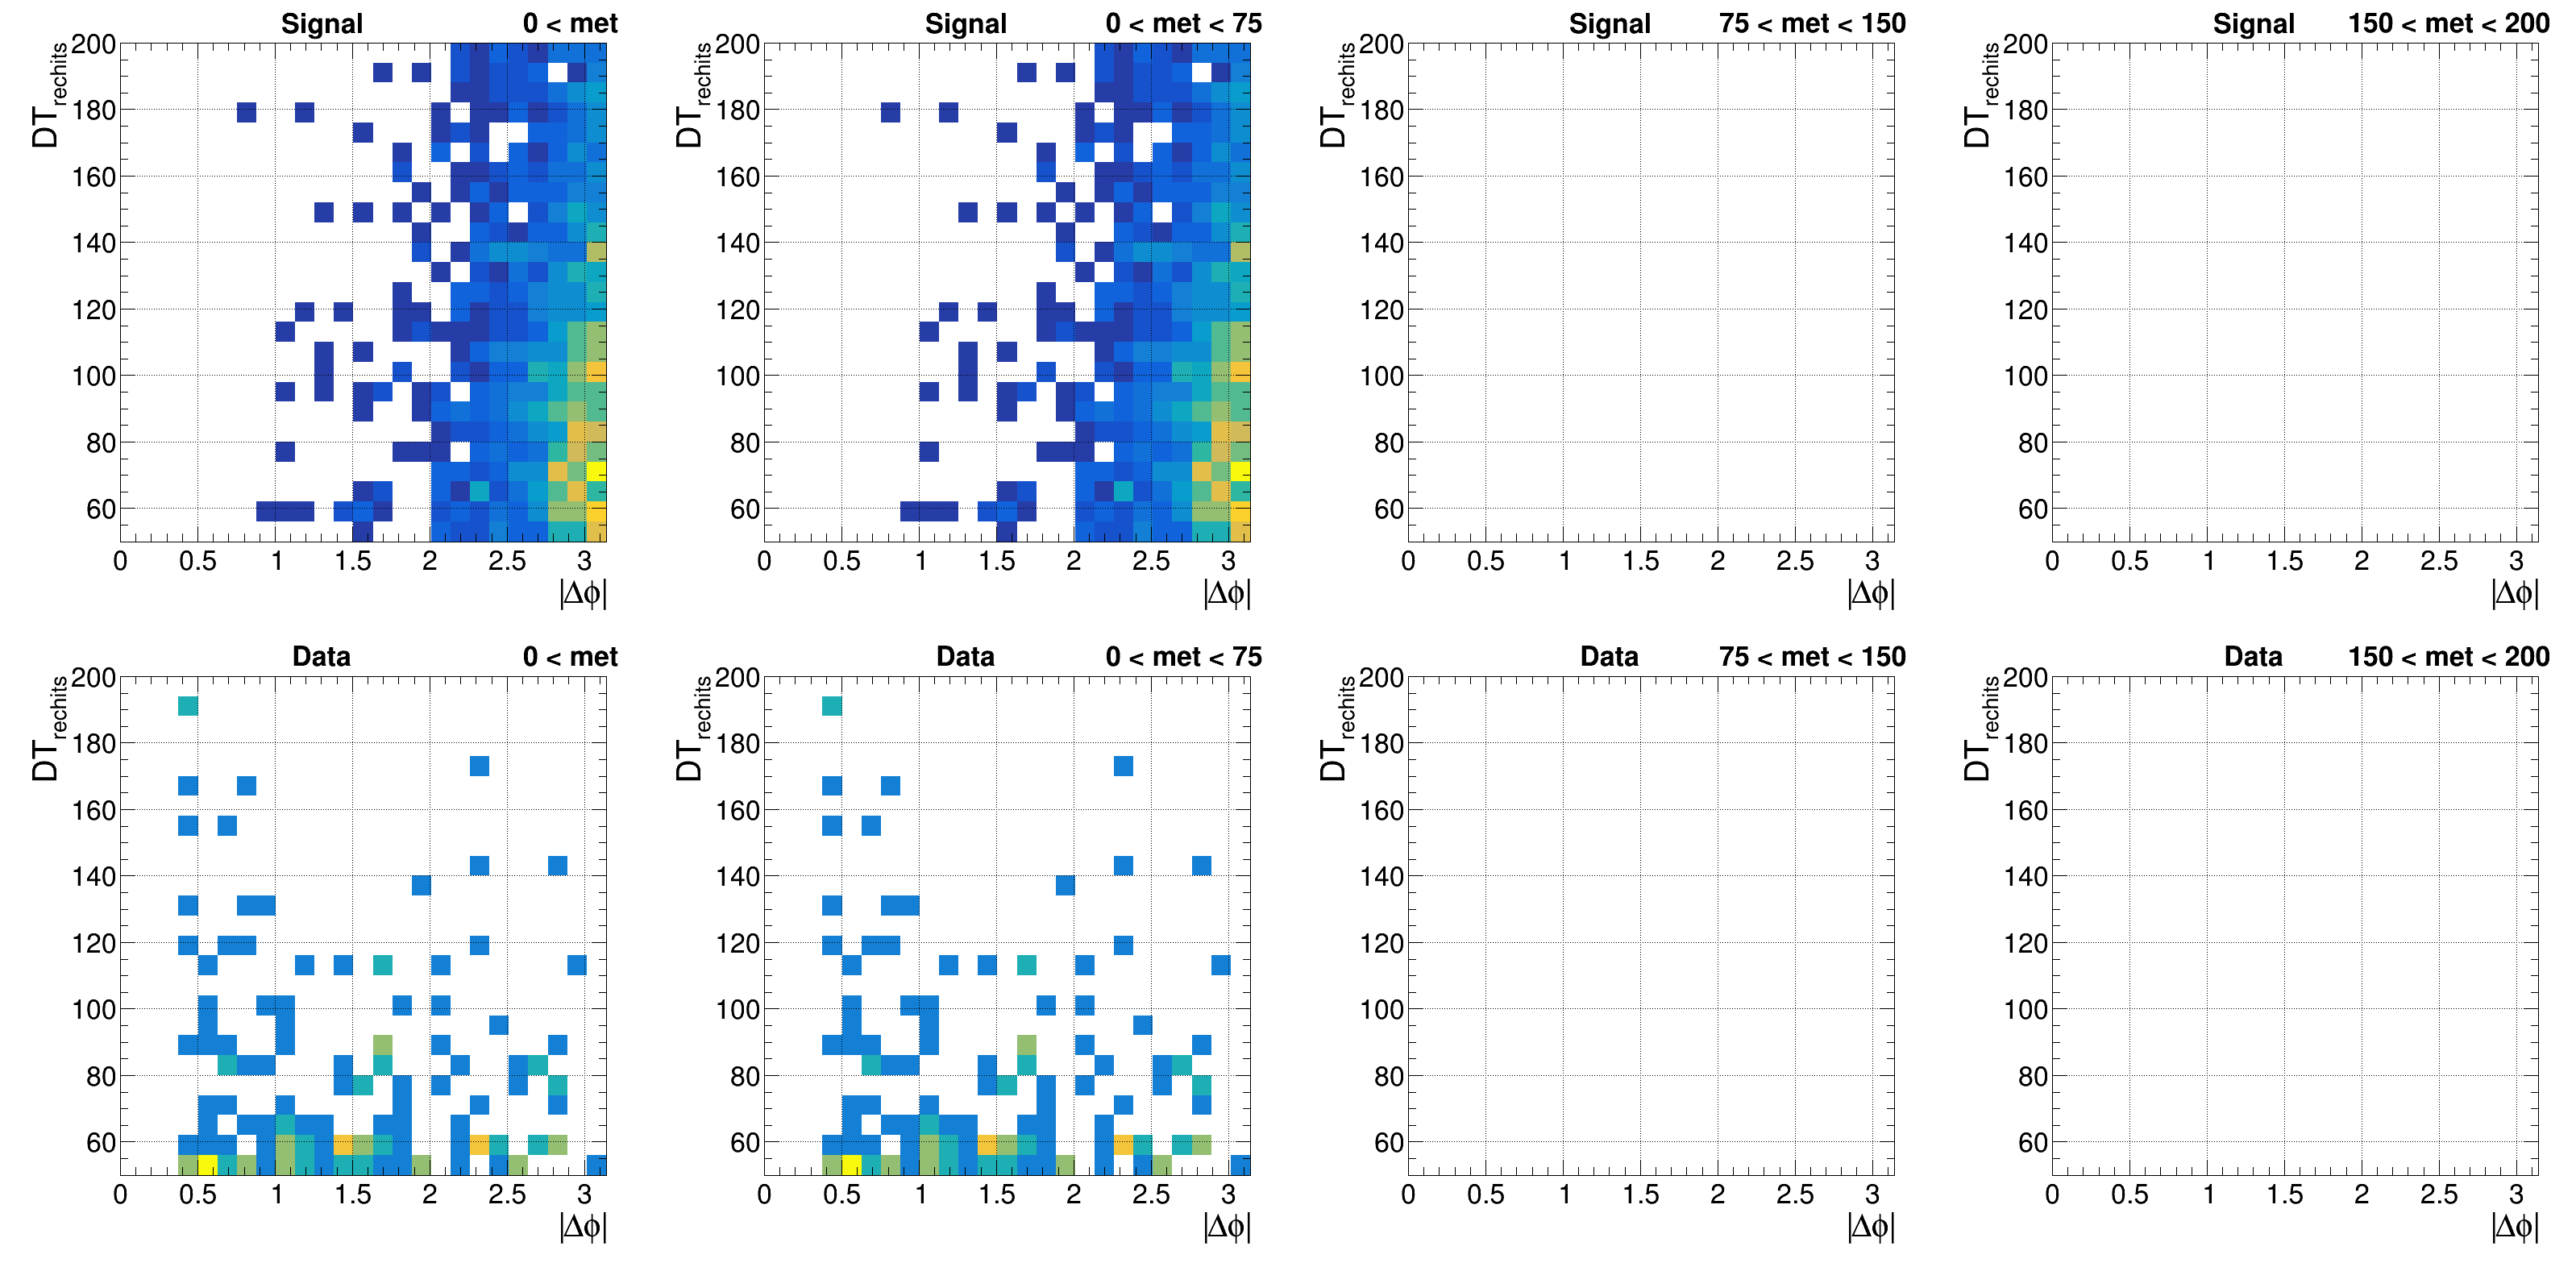

In [105]:
canvas = TCanvas('','',4*800,2*800)
canvas.Divide(4,2)


for i, ft in enumerate(['0 < met', '(0 < met) & (met < 75)', '(75 < met) & (met < 150)', '(150 < met) & (met < 200)']):
    for j in range(2):
        canvas.cd(i+1 + 4*j).SetGrid()
        # canvas.cd(i+1).SetLogz()
        # rdfn = ['mc_raw', 'r2_raw', 'mc', 'r3'][j]
        rdfn = ['mc', 'r3'][j]
        hh = rdfs[rdfn].Filter(ft).Histo2D(('',ft+';|#Delta#phi|;DT_{rechits};',25,0,PI,25,50,200),'tag_dPhi','dtSize')#.GetValue()
        hh.Draw('col')

        latex = TLatex()
        latex.SetTextSize(0.05)
        latex.SetTextAlign(33)
        _ft = ft.replace('(', '').replace(')', '').replace('met & met', 'met')
        latex.DrawLatexNDC(1, 1, _ft)
        latex.SetTextAlign(23)
        latex.DrawLatexNDC(0.5, 1, 'Data' if j else 'Signal')
        gc.extend([hh, latex])
canvas.Draw()

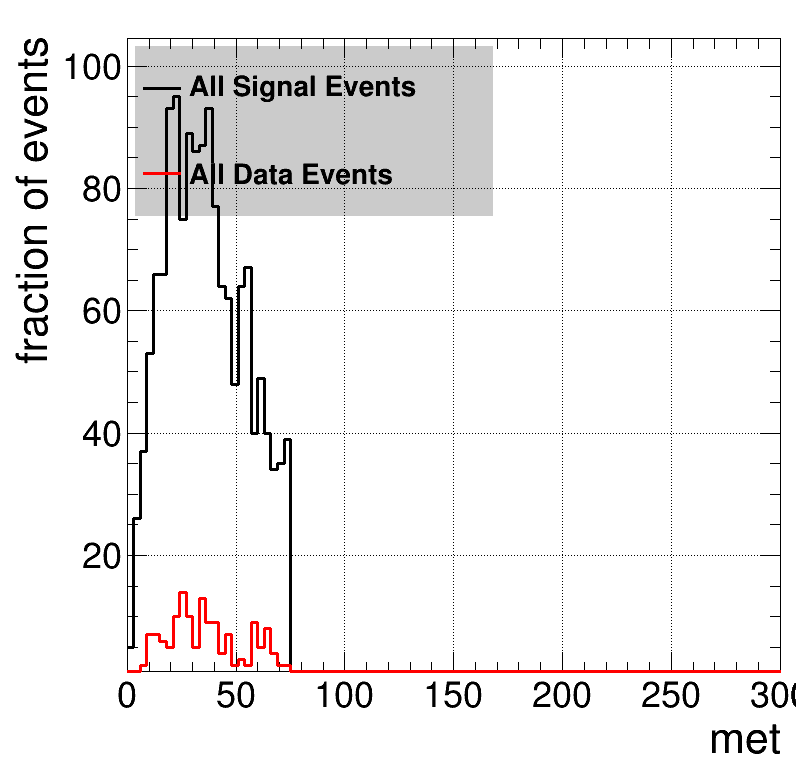

In [106]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.17, 0.72, 0.62, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'dtJetVetoPt'
txy_label = f';{xv};fraction of events'
form = ('',txy_label,100,0,100)

xv = 'dtNHitStation1'
txy_label = f';{xv};fraction of events'
form = ('',txy_label,100,0,100)

xv = 'met'
txy_label = f';{xv};fraction of events'
form = ('',txy_label,100,0,300)


# **** #

h1 = rdfs['mc'].Histo1D(form,xv).GetValue()
h1.SetName('All Signal Events')
h2 = rdfs['r3'].Histo1D(form,xv).GetValue()
h2.SetName('All Data Events')
# h2 = rdfs['mc'].Filter(f'met<100').Histo1D(('ME_{T} < 100 GeV',txy_label,20,0,PI),xv).GetValue()
# h3 = rdfs['mc'].Filter(f'met>200').Histo1D(('200 GeV < ME_{T}',txy_label,20,0,PI),xv).GetValue()
# h4 = rdfs['mc'].Filter(f'(100<met) && (met<200)').Histo1D(('100 < ME_{T} < 200 GeV',txy_label,20,0,PI),xv).GetValue()
hhs = [h1,h2]#,h3, h4]
hmax = max([h.GetMaximum() for h in hhs])
# hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    # hh.Scale(1/hh.Integral())
    hh.SetMinimum(1)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')


legend.Draw()
canvas.Draw()


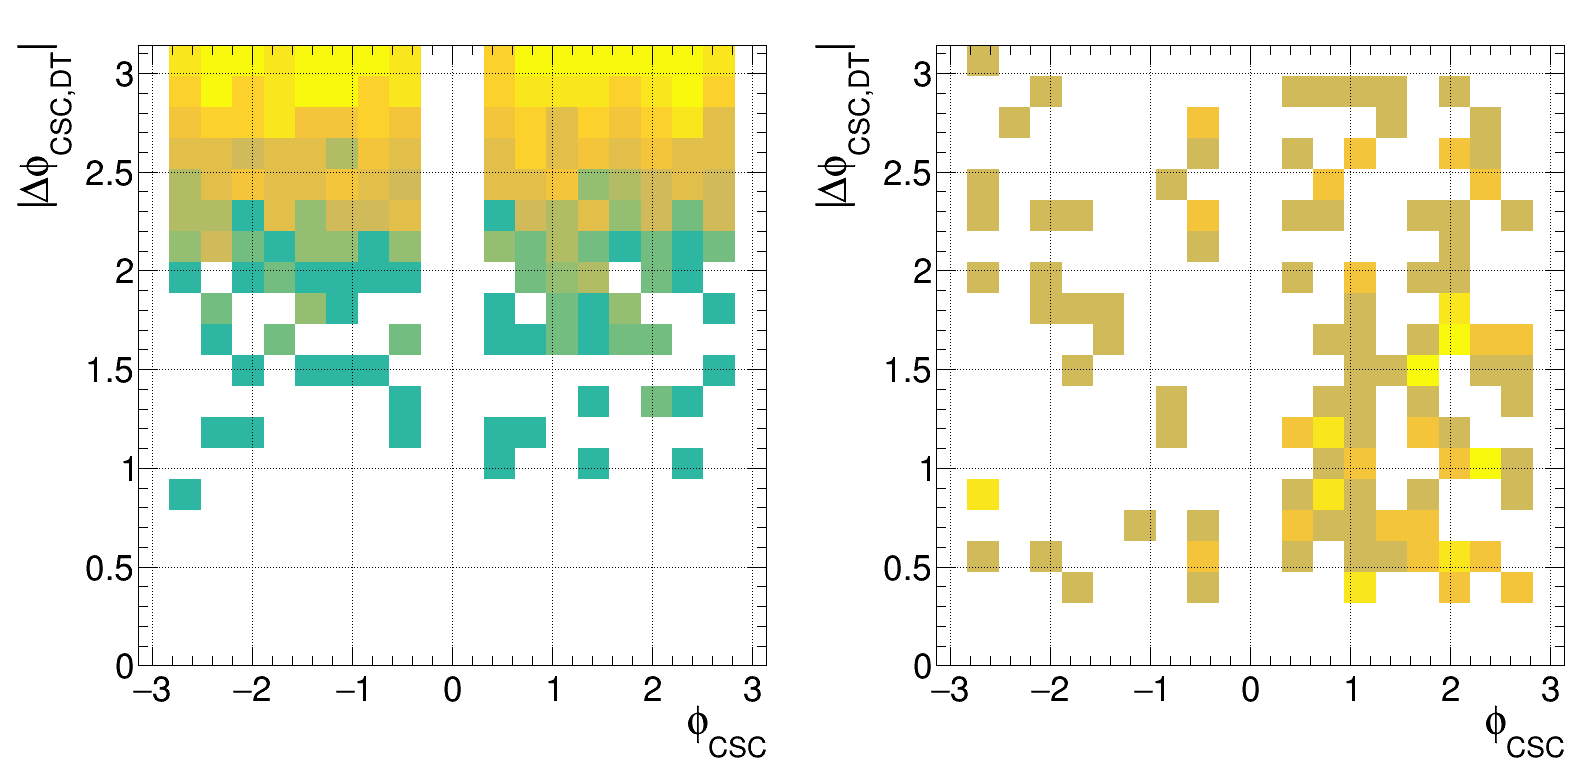

In [107]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)
# canvas.SetGrid()

# legend = TLegend(0.17, 0.72, 0.62, 0.94)
# legend.SetBorderSize(0)
# legend.SetFillColorAlpha(rt.kBlack, 0.2)
# legend.SetTextSize(0.04)
# legend.SetMargin(0.15)

nb = 20
xv, yv = 'met', 'tag_dPhi'
txy_label = ';Missing E_{T} [GeV];|#Delta#phi_{CSC,DT}|;fraction of events'
bins = (nb, np.logspace(0, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
logxyz = (True, False, True)

# nb = 20
# xv, yv = 'met', 'dtSize'
# txy_label = ';Missing E_{T} [GeV];DT N_{Rechits};fraction of events'
# bins = (nb, np.logspace(0, np.log10(300), nb+1), nb, np.logspace(np.log10(40), np.log10(1000), nb+1))
# logxyz = (True, True, True)

# nb = 20
# xv, yv = 'dtSize', 'tag_dPhi'
# txy_label = ';DT N_{Rechits};|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.logspace(np.log10(40), np.log10(1000), nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (True, False, True)

# nb = 20
# xv, yv = 'cscEta', 'tag_dPhi'
# txy_label = ';#eta_{CSC};|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.linspace(-2, 2, nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (False, False, True)

nb = 20
xv, yv = 'dtPhi', 'tag_dPhi'
txy_label = ';#phi_{CSC};|#Delta#phi_{CSC,DT}|;fraction of events'
bins = (nb, np.linspace(-np.pi, np.pi, nb+1), nb, np.linspace(0,PI,nb+1))
logxyz = (False, False, True)


# **** #

h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
h2 = rdfs['r3'].Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()

hhs = [h1,h2]
# hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetGrid()
    if logxyz[0]:
        canvas.cd(ih + 1).SetLogx()
    if logxyz[1]:
        canvas.cd(ih + 1).SetLogy()
    if logxyz[2]:
        canvas.cd(ih + 1).SetLogz()
    
    # hh.Scale(1/hh.Integral())
    # hh.SetMinimum(0)
    # hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('col')


# legend.Draw()
canvas.Draw()


In [108]:
MAKE_DATACARDS = True

def calc_abcd(data, dphi_cond, size_cond, dphi_flip, cond = True):
    dphi_cond, size_cond = data['tag_dPhi'] > dphi_cond, data['dtSize'] > size_cond
    if dphi_flip:
        dphi_cond = ~dphi_cond
    a = np.sum(data['weight'][(dphi_cond & size_cond) & cond])
    b = np.sum(data['weight'][(dphi_cond & ~size_cond) & cond])
    c = np.sum(data['weight'][(~dphi_cond & ~size_cond) & cond])
    d = np.sum(data['weight'][(~dphi_cond & size_cond) & cond])
    return [a,b,c,d]#[x.GetValue() for x in (a, b, c, d)]


def calc_abcd_rdf(rdf, dphi_cond, size_cond, dphi_flip):
    dphi_cond, size_cond = f'tag_dPhi {"<" if dphi_flip else ">"} {dphi_cond}', f'dtSize > {size_cond}'
    a = rdf.Filter(f'({dphi_cond}) && ({size_cond})').Sum('weight')
    b = rdf.Filter(f'({dphi_cond}) && !({size_cond})').Sum('weight')
    c = rdf.Filter(f'!({dphi_cond}) && !({size_cond})').Sum('weight')
    d = rdf.Filter(f'!({dphi_cond}) && ({size_cond})').Sum('weight')
    return [a,b,c,d]#[x.GetValue() for x in (a, b, c, d)]

# @nb.jit(nopython=False,forceobj=True)
def _calc_abcd(data, dphi_cond, size_cond, dphi_flip, cond = True, loocv = False):
    wt, dp, sz = data['weight'][cond], data['tag_dPhi'][cond], data['dtSize'][cond]
    nev = wt.shape[0]
    if nev == 0:
        return [0, 0, 0, 0]

    mask = np.ones_like(wt, dtype=bool)
    if isinstance(loocv, float):
        if loocv < 1:
            loocv = int(loocv * nev)
    elif isinstance(loocv, bool):
        if loocv:
            loocv = nev
        else:
            loocv = 1
    loocv = min(int(loocv), nev)

    dphi_cond, size_cond = dp > dphi_cond, sz > size_cond
    if dphi_flip:
        dphi_cond = ~dphi_cond

    # print(loocv)
    _a, _b, _c, _d = [], [], [], []
    for i in range(loocv):
        idx = np.random.randint(nev)
        if loocv > 1:
            mask[idx] = False

        _a.append(np.sum(wt[(dphi_cond & size_cond) & mask]))
        _b.append(np.sum(wt[(dphi_cond & ~size_cond) & mask]))
        _c.append(np.sum(wt[(~dphi_cond & ~size_cond) & mask]))
        _d.append(np.sum(wt[(~dphi_cond & size_cond) & mask]))

        mask[idx] = True

    return [sum(x)/len(x) for x in (_a,_b,_c,_d)]#a,b,c,d]#[x.GetValue() for x in (a, b, c, d)]

# @nb.njit
# @nb.jit(nopython=False,forceobj=True)
def scan_abcd(grid, _data_mc, _data_r3, loocv=False):
    grid = np.asarray(grid).reshape(-1, 3)

    abcd_mc = np.empty((grid.shape[0],4))
    abcdL_mc = np.empty((grid.shape[0],4))
    abcdH_mc = np.empty((grid.shape[0],4))

    abcd_r3 = np.empty((grid.shape[0],4))
    abcdL_r3 = np.empty((grid.shape[0],4))
    abcdH_r3 = np.empty((grid.shape[0],4))
    for imet, (met, dphi, size) in enumerate(grid):
        dphi_flip_l, dphi_flip_h = False, True

        mc_median_dphi_l = np.median(_data_mc['tag_dPhi'][_data_mc['met'] < met])
        mc_median_dphi_h = np.median(_data_mc['tag_dPhi'][_data_mc['met'] > met])
        r3_median_dphi = np.median(_data_r3['tag_dPhi'])
        if mc_median_dphi_l < r3_median_dphi:
            dphi_flip_l = True
        if mc_median_dphi_h > r3_median_dphi:
            dphi_flip_h = False
        
        abcd_mc[imet] = _calc_abcd(_data_mc, dphi, size, False, loocv=loocv)
        abcdL_mc[imet] = _calc_abcd(_data_mc, dphi, size, dphi_flip_l, _data_mc['met'] < met, loocv=loocv)
        abcdH_mc[imet] = _calc_abcd(_data_mc, dphi, size, dphi_flip_h, _data_mc['met'] > met, loocv=loocv)
        
        abcd_r3[imet] = _calc_abcd(_data_r3, dphi, size, False, loocv=loocv)
        abcdL_r3[imet] = _calc_abcd(_data_r3, dphi, size, dphi_flip_l, _data_r3['met'] < met, loocv=loocv)
        abcdH_r3[imet] = _calc_abcd(_data_r3, dphi, size, dphi_flip_h, _data_r3['met'] > met, loocv=loocv)
    return (abcd_mc, abcd_r3), (abcdL_mc, abcdL_r3), (abcdH_mc, abcdH_r3)

met_dphi_size_grid = np.array(np.meshgrid(METS,DPHIS,DTSIZES)).T.reshape(-1,3)
met_abcds = {}

s2b_dict = { k1 : {
    k2 : [] for k2 in ('ct', 'met', 'dphi', 'dtsize',
                       'a_mc', 'b_mc', 'c_mc', 'd_mc',
                        'a_r3', 'b_r3', 'c_r3', 'd_r3')
    } for k1 in ('all', 'low', 'high')
}

if MAKE_DATACARDS:
    os.system(f'rm -f {DATA_DIR}/datacard_scan/datacard*')
    data_mc = rdfs['mc'].AsNumpy(['weight','met','tag_dPhi','dtSize', 'cscCTau', 'dtCTau'])
    data_r3 = rdfs['r3'].AsNumpy(['weight','met','tag_dPhi','dtSize', 'cscCTau', 'dtCTau'])

    abcd_mc, abcdL_mc, abcdH_mc, abcd_r3, abcdL_r3, abcdH_r3 = [],[],[],[],[],[]#(np.zeros((met_dphi_size_grid.shape[0],4)) for i in range(4))


    # for ct in CTAUS: #! Can I use the same boundaries and cuts for all ctaus or should I reoptimize?
    (abcd_mc, abcd_r3), (abcdL_mc, abcdL_r3), (abcdH_mc, abcdH_r3) = scan_abcd(met_dphi_size_grid, data_mc, data_r3, loocv=False)
    # for imet, (met, dphi, size) in enumerate(met_dphi_size_grid):
    #     # abcd_mc.append(calc_abcd(rdf_mc, dphi, size, False))
    #     # abcdL_mc.append(calc_abcd(rdf_mc.Filter(f'met < {met}'), dphi, size, False))
    #     # abcdH_mc.append(calc_abcd(rdf_mc.Filter(f'met > {met}'), dphi, size, True))
        
    #     # abcd_r3.append(calc_abcd(rdf_r3, dphi, size, False))
    #     # abcdL_r3.append(calc_abcd(rdf_r3.Filter(f'met < {met}'), dphi, size, False))
    #     # abcdH_r3.append(calc_abcd(rdf_r3.Filter(f'met > {met}'), dphi, size, True))
        
    #     abcd_mc.append(calc_abcd(data_mc, dphi, size, False))
    #     abcdL_mc.append(calc_abcd(data_mc, dphi, size, False, data_mc['met'] < met))
    #     abcdH_mc.append(calc_abcd(data_mc, dphi, size, True, data_mc['met'] > met))
        
    #     abcd_r3.append(calc_abcd(data_r3, dphi, size, False))
    #     abcdL_r3.append(calc_abcd(data_r3, dphi, size, False, data_r3['met'] < met))
    #     abcdH_r3.append(calc_abcd(data_r3, dphi, size, True, data_r3['met'] > met))

    # abcd_mc = np.asarray(abcd_mc)
    # abcdL_mc = np.asarray(abcdL_mc)
    # abcdH_mc = np.asarray(abcdH_mc)
    
    # abcd_r3 = np.asarray(abcd_r3)
    # abcdL_r3 = np.asarray(abcdL_r3)
    # abcdH_r3 = np.asarray(abcdH_r3)

    # gv = np.vectorize(lambda x: x.GetValue())
    # abcd_mc = gv(abcd_mc)
    # abcdL_mc = gv(abcdL_mc)
    # abcdH_mc = gv(abcdH_mc)
    # abcd_r3 = gv(abcd_r3)
    # abcdL_r3 = gv(abcdL_r3)
    # abcdH_r3 = gv(abcdH_r3)

    a0_r3 = abcd_r3[:,0] * 1. # make a copy
    a0L_r3 = abcdL_r3[:,0] * 1. # make a copy
    a0H_r3 = abcdH_r3[:,0] * 1. # make a copy

    abcd_r3[:,0] = np.divide(abcd_r3[:,1]*abcd_r3[:,3],
                              abcd_r3[:,2],
                              out=1e9 * np.ones_like(abcd_r3[:,0]),#np.zeros_like(abcd_r3[:,0]),
                              where=abcd_r3[:,2]>0)
    
    abcdL_r3[:,0] = np.divide(abcdL_r3[:,1]*abcdL_r3[:,3],
                              abcdL_r3[:,2],
                              out=1e9 * np.ones_like(abcdL_r3[:,0]),#np.zeros_like(abcdL_r3[:,0]),
                              where=abcdL_r3[:,2]>0)

    abcdH_r3[:,0] = np.divide(abcdH_r3[:,1]*abcdH_r3[:,3],
                              abcdH_r3[:,2],
                              out=1e9 * np.ones_like(abcdH_r3[:,0]),#np.zeros_like(abcdH_r3[:,0]),
                              where=abcdH_r3[:,2]>0)

    abcd_r3[abcd_r3[:,1]+abcd_r3[:,3]==0,0] = 0
    abcdL_r3[abcdL_r3[:,1]+abcdL_r3[:,3]==0,0] = 0
    abcdH_r3[abcdH_r3[:,1]+abcdH_r3[:,3]==0,0] = 0

    # psuedo closure test?
    print(np.sum(np.abs(abcd_r3[:,0]-a0_r3) > np.sqrt(a0_r3+1)) / len(a0_r3))
    print(np.sum(np.abs(abcdL_r3[:,0]-a0L_r3) > np.sqrt(a0L_r3+1)) / len(a0L_r3))
    print(np.sum(np.abs(abcdH_r3[:,0]-a0H_r3) > np.sqrt(a0H_r3+1)) / len(a0H_r3))
    abcd_r3[np.abs(abcd_r3[:,0]-a0_r3) > np.sqrt(a0_r3+1),0] = 1e9
    abcdL_r3[np.abs(abcdL_r3[:,0]-a0L_r3) > np.sqrt(a0L_r3+1),0] = 1e9
    abcdH_r3[np.abs(abcdH_r3[:,0]-a0H_r3) > np.sqrt(a0H_r3+1),0] = 1e9

    # abcd_r3[abcd_r3[:,2]==0] = 999# & ((abcd_r3[:,1]+abcd_r3[:,2])!=0),0] = 999
    # abcdL_r3[abcdL_r3[:,2]==0] = 999# & ((abcdL_r3[:,1]+abcdL_r3[:,2])!=0),0] = 999
    # abcdH_r3[abcdH_r3[:,2]==0] = 999# & ((abcdH_r3[:,1]+abcdH_r3[:,2])!=0),0] = 999

    abcd_mc[np.any(abcd_mc == 0, axis=1),0] = 0
    abcdL_mc[np.any(abcdL_mc == 0, axis=1),0] = 0
    abcdH_mc[np.any(abcdH_mc == 0, axis=1),0] = 0

    for imet, (met, dphi, size) in enumerate(met_dphi_size_grid):
        if met not in met_abcds:
            met_abcds[met] = np.array([
                [dphi, size, *abcd_mc[imet], *abcd_r3[imet]],
                [dphi, size, *abcdL_mc[imet], *abcdL_r3[imet]],
                [dphi, size, *abcdH_mc[imet], *abcdH_r3[imet]]
            ])
        else:
            # if (np.all(abcd_r3[imet]>0) or np.sum(abcd_r3[imet,1:]) < 3 or met_abcds[met][0,6] == 0) and \
            if met_abcds[met][0,2]/(met_abcds[met][0,6] if met_abcds[met][0,6] else 1e9)**(1/2) < abcd_mc[imet,0]/(abcd_r3[imet,0] if abcd_r3[imet,0] else 1e9)**(1/2):
                met_abcds[met][0] = [dphi, size, *abcd_mc[imet], *abcd_r3[imet]]

            # if (np.all(abcdL_r3[imet]>0) or np.sum(abcdL_r3[imet,1:]) < 3 or met_abcds[met][1,6] == 0) and \
            if met_abcds[met][1,2]/(met_abcds[met][1,6] if met_abcds[met][1,6] else 1e9)**(1/2) < abcdL_mc[imet,0]/(abcdL_r3[imet,0] if abcdL_r3[imet,0] else 1e9)**(1/2):
                met_abcds[met][1] = [dphi, size, *abcdL_mc[imet], *abcdL_r3[imet]]

            # if (np.all(abcdH_r3[imet]>0) or np.sum(abcdH_r3[imet,1:]) < 3 or met_abcds[met][2,6] == 0) and \
            if met_abcds[met][2,2]/(met_abcds[met][2,6] if met_abcds[met][2,6] else 1e9)**(1/2) < abcdH_mc[imet,0]/(abcdH_r3[imet,0] if abcdH_r3[imet,0] else 1e9)**(1/2):
                met_abcds[met][2] = [dphi, size, *abcdH_mc[imet], *abcdH_r3[imet]]

    mc_wt0, r3_wt0 = data_mc['weight']*1.0, data_r3['weight']*1.0 # create copies
    for met, stats in met_abcds.items():
        for i, stat in enumerate(stats):
            # print(met, i,stat)
            dphi, size = stat[0], stat[1]
            # abcd_sig = stat[2:6]
            # abcd_bkg = stat[6:10]
            for ct in CTAUS:
                # print(ct)
                if ct != CTAU:
                    # data_mc['weight'] *= weight_calc(data_mc['cscCTau']+data_mc['dtCTau'], ct / 10, CTAU / 10)
                    data_mc['weight'] *= weight_calc(data_mc['dtCTau'], ct / 10, CTAU / 10)
                abcd_sig, abcd_bkg = scan_abcd([met, dphi, size], data_mc, data_r3)[i]
                data_mc['weight'] = mc_wt0 * 1.0 # multiply to coerce a copy
                # print(np.sum(mc_wt0))

                abcd_bkg[:,0] = np.divide(abcd_bkg[:,1]*abcd_bkg[:,3],
                              abcd_bkg[:,2],
                              out=np.zeros_like(abcd_bkg[:,0]),
                              where=abcd_bkg[:,2]>0)
                # print(abcd_sig, abcd_bkg)
                abcd_sig, abcd_bkg = abcd_sig[0], abcd_bkg[0]

                # norm = 10 ** int(np.log10(5 / sum(abcd_sig)))# if sum(abcd_sig) else 1
                norm = 5 / sum(abcd_sig)# if sum(abcd_sig) else 1
                # also try norm = min(1, norm)?
                # norm = min(1, norm)
                
                s2b = abcd_sig[0] / (abcd_bkg[0]**(1/2) if abcd_bkg[0] else 1)
                lv, le = 0 , 0
                # ct = 1000

                if i == 0:
                    p, pp = '', 'all'
                elif i == 1:
                    p, pp = 'L', 'low'
                elif i == 2:
                    p, pp = 'H', 'high'

                s2b_dict[pp]['ct'].append(ct)
                s2b_dict[pp]['met'].append(met)
                s2b_dict[pp]['dphi'].append(dphi)
                s2b_dict[pp]['dtsize'].append(size)
                s2b_dict[pp]['a_mc'].append(abcd_mc[0])
                s2b_dict[pp]['b_mc'].append(abcd_mc[1])
                s2b_dict[pp]['c_mc'].append(abcd_mc[2])
                s2b_dict[pp]['d_mc'].append(abcd_mc[3])
                s2b_dict[pp]['a_r3'].append(abcd_bkg[0])
                s2b_dict[pp]['b_r3'].append(abcd_bkg[1])
                s2b_dict[pp]['c_r3'].append(abcd_bkg[2])
                s2b_dict[pp]['d_r3'].append(abcd_bkg[3])
                fdc = f'datacard_ct{ct:0>8.0f}_met{met:0>3.0f}_{pp}.txt'

                str_dc = f"""# norm {norm}
# CTAU {ct}
# ABCD_DPHI {dphi}
# ABCD_SIZE {size}
# ABCD_FLIP {i == 2}
# S2B,LIMIT {s2b} {lv} {le}
imax 4
jmax 1
kmax *
shapes * * FAKE
---------------
---------------
bin \t chA \t chB \t chC \t chD
observation \t {abcd_bkg[0]:.3f} \t {abcd_bkg[1]:.3f} \t {abcd_bkg[2]:.3f} \t {abcd_bkg[3]:.3f}
------------------------------
bin \t chA \t chA \t chB \t chB \t chC \t chC \t chD \t chD
process \t sig \t bkg \t sig \t bkg \t sig \t bkg \t sig \t bkg
process \t 0 \t 1 \t 0 \t 1 \t 0 \t 1 \t 0 \t 1
rate \t {abcd_sig[0]:.6e} \t 1 \t {abcd_sig[1]:.6e} \t 1 \t {abcd_sig[2]:.6e} \t 1 \t {abcd_sig[3]:.6e} \t 1
------------------------------
single_A{p} \t rateParam \t chA \t bkg \t (@0*@2/@1) \t single_B{p},single_C{p},single_D{p}
single_B{p} \t rateParam \t chB \t bkg \t {abcd_bkg[1]:.3f} \t [0,{max(7, 7*abcd_bkg[1]):.3f}]
single_C{p} \t rateParam \t chC \t bkg \t {abcd_bkg[2]:.3f} \t [0,{max(7, 7*abcd_bkg[2]):.3f}]
single_D{p} \t rateParam \t chD \t bkg \t {abcd_bkg[3]:.3f} \t [0,{max(7, 7*abcd_bkg[3]):.3f}]
norm rateParam * sig 1
single_lumi \t lnN \t 1.2 \t - \t 1.2 \t - \t 1.2 \t - \t 1.2 \t -
"""
                with open(f"{DATA_DIR}/datacard_scan/{fdc}", "w") as fdc:
                    fdc.write(str_dc)

        with open(f'{DATA_DIR}/s2b_dict.pkl', 'wb') as f:
            pickle.dump(s2b_dict, f)
        with open(f'{DATA_DIR}/met_abcds.pkl', 'wb') as f:
            pickle.dump(met_abcds, f)
    else:
        with open(f'{DATA_DIR}/s2b_dict.pkl', 'rb') as f:
            s2b_dict = pickle.load(f)
        with open(f'{DATA_DIR}/met_abcds.pkl', 'rb') as f:
            met_abcds = pickle.load(f)


0.4807975378027566
0.4807975378027566
0.0


/tmp/ipykernel_22932/1927432616.py:228: RuntimeWarning: divide by zero encountered in scalar divide
  norm = 5 / sum(abcd_sig)# if sum(abcd_sig) else 1


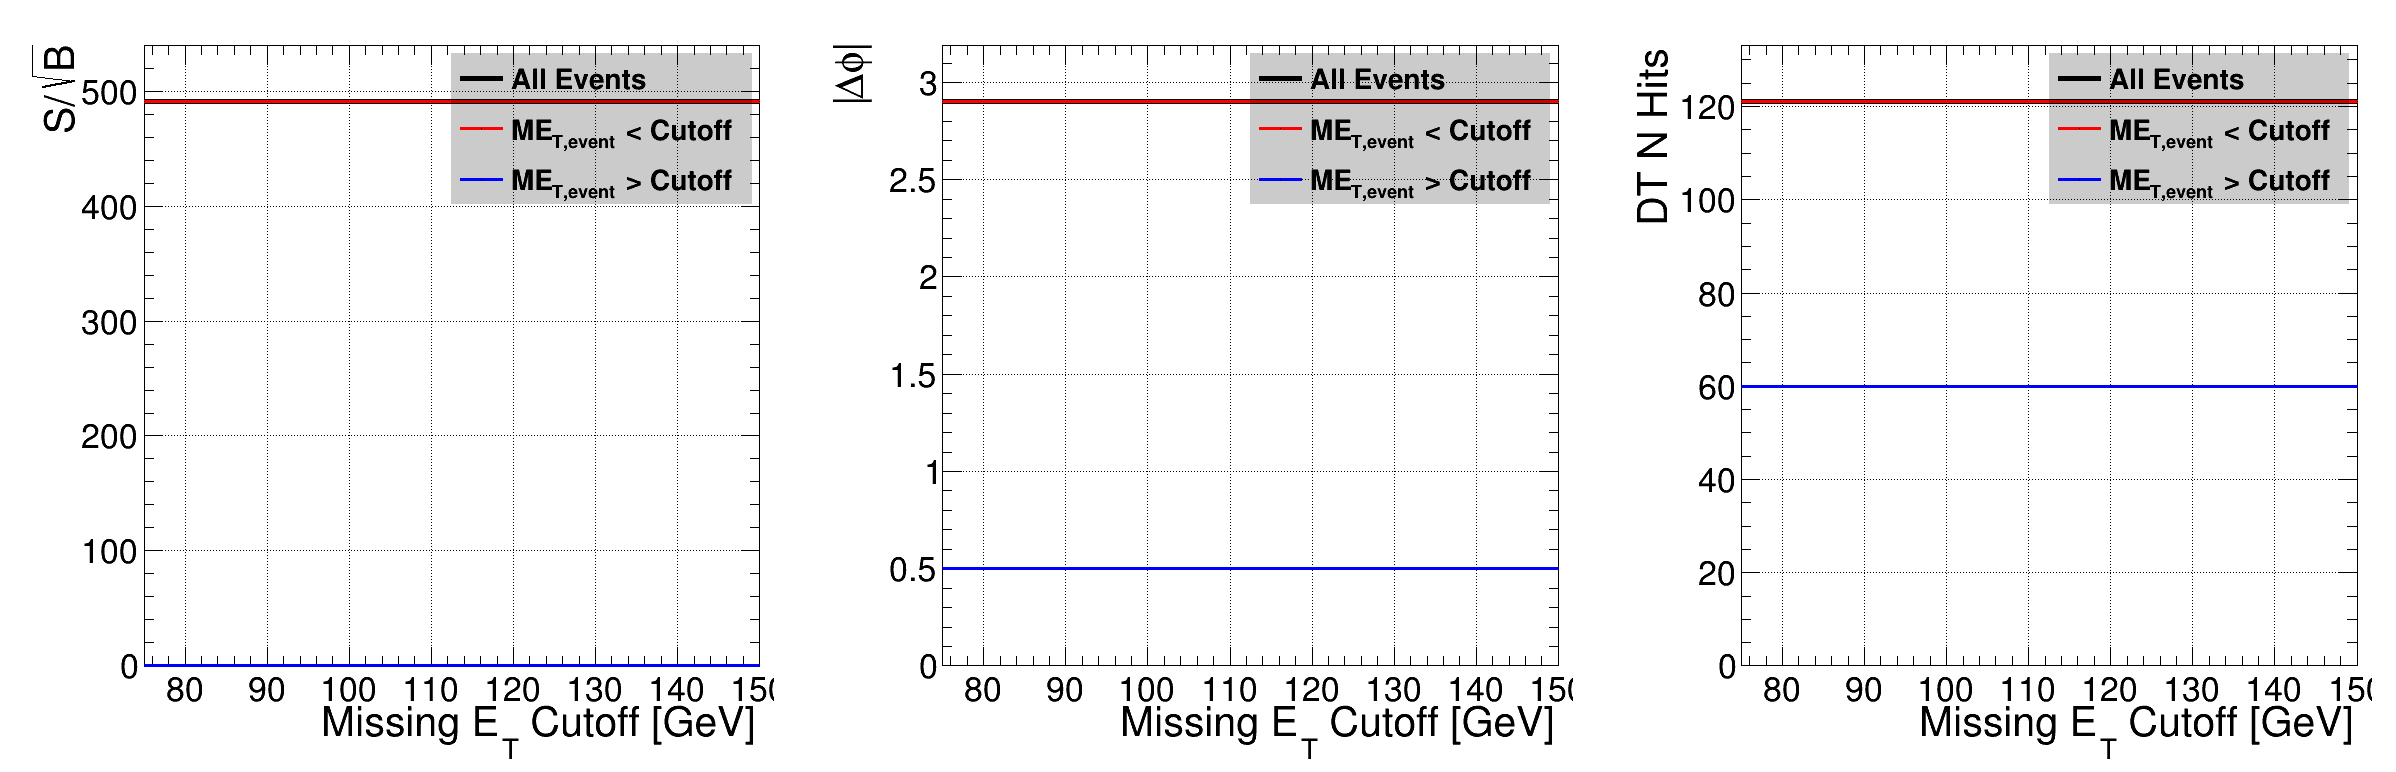

In [109]:
canvas = TCanvas('','',3*800,800)
canvas.Divide(3,1)


divide2 = lambda a,b: a/(b**(1/2)) if b else a
mets = np.array(list(met_abcds.keys())) * 1.0
# limit_ctau_idx = (limit_dict['all']['ctau'] == CTAU)

dphi = np.array([met_abcds[met][0,0] for met in mets])
size = np.array([met_abcds[met][0,1] for met in mets])
s2b = np.array([divide2(met_abcds[met][0,2],met_abcds[met][0,6]) for met in mets])
# limit = np.array([limit_dict['all']['limit'][(limit_dict['all']['met'] == met) & limit_ctau_idx] for met in mets])

dphiL = np.array([met_abcds[met][1,0] for met in mets])
sizeL = np.array([met_abcds[met][1,1] for met in mets])
s2bL = np.array([divide2(met_abcds[met][1,2],met_abcds[met][1,6]) for met in mets])
# limitL = np.array([limit_dict['low']['limit'][(limit_dict['low']['met'] == met) & limit_ctau_idx] for met in mets])
                 
dphiH = np.array([met_abcds[met][2,0] for met in mets])
sizeH = np.array([met_abcds[met][2,1] for met in mets])
s2bH = np.array([divide2(met_abcds[met][2,2],met_abcds[met][2,6]) for met in mets])
# limitH = np.array([limit_dict['high']['limit'][(limit_dict['high']['met'] == met) & limit_ctau_idx] for met in mets])

# limitC = np.array([limit_dict['comb']['limit'][(limit_dict['comb']['met'] == met) & limit_ctau_idx] for met in mets])

# s2b = (s2bL*s2bH)**(1/2)
# s2b = (s2bL**2 + s2bH**2)**(1/2)
# **** #

for iv, (values, ylabel) in enumerate([([s2b,s2bL,s2bH], 'S/#sqrt{B}'),
                                       ([dphi,dphiL,dphiH], '|#Delta#phi|'),
                                       ([size,sizeL,sizeH], 'DT N Hits')]):
    canvas.cd(iv + 1).SetGrid()
    legend = TLegend(0.57, 0.74, 0.97, 0.94)
    legend.SetBorderSize(0)
    legend.SetFillColorAlpha(rt.kBlack, 0.2)
    legend.SetTextSize(0.04)
    legend.SetMargin(0.2)
    gc.append(legend)

    xlabel = 'Missing E_{T} Cutoff [GeV]'
    names = ['All Events', 'ME_{T,event} < Cutoff', 'ME_{T,event} > Cutoff', 'Combined']
    hmin, hmax = 0, np.max(values)*1.1
    for igr, val in enumerate(values):
        gr = TGraph(len(mets),mets,val)
        gr.GetXaxis().SetLimits(np.min(mets), np.max(mets))
        gr.SetMinimum(0)#hmin)
        gr.SetMaximum(hmax)
        gr.SetName(names[igr])
        gr.GetXaxis().SetTitle(xlabel)
        gr.GetYaxis().SetTitle(ylabel)

        gr.SetLineWidth(3)
        if igr == 0:
            gr.SetLineWidth(5)

        gr.SetLineColor(SCL[igr])
        gr.Draw(('' if igr else 'A')+' LP')
        legend.AddEntry(gr,gr.GetName(),'LP')
        gc.append(gr)

    legend.Draw()
canvas.Draw()

In [110]:
met = METS[0]
dphi, size = met_abcds[met][2][:2]
print(f'{met=:.1f}, {dphi=:.2f} {size=:.1f}')
# a = rdfs['r3'].Filter(f'(met>{met}) && (tag_dPhi <  {dphi}) && (dtSize >  {size})').Count()
# b = rdfs['r3'].Filter(f'(met>{met}) && (tag_dPhi <  {dphi}) && (dtSize <= {size})').Count()
# c = rdfs['r3'].Filter(f'(met>{met}) && (tag_dPhi >= {dphi}) && (dtSize <  {size})').Count()
# d = rdfs['r3'].Filter(f'(met>{met}) && (tag_dPhi >= {dphi}) && (dtSize >= {size})').Count()
a = rdfs['r3'].Filter(f'(tag_dPhi <  {dphi}) && (dtSize >  {size})').Count()
b = rdfs['r3'].Filter(f'(tag_dPhi <  {dphi}) && (dtSize <= {size})').Count()
c = rdfs['r3'].Filter(f'(tag_dPhi >= {dphi}) && (dtSize <  {size})').Count()
d = rdfs['r3'].Filter(f'(tag_dPhi >= {dphi}) && (dtSize >= {size})').Count()
a,b,c,d = a.GetValue(),b.GetValue(),c.GetValue(),d.GetValue()
a,b,c,d, met_abcds[met][2]

met=75.0, dphi=0.50 size=60.0


(7,
 4,
 59,
 76,
 array([ 0.5, 60. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]))

0 met > 0 2.900000000000002 121.0
1 met < 75 2.900000000000002 121.0
2 met > 75 0.5 60.0


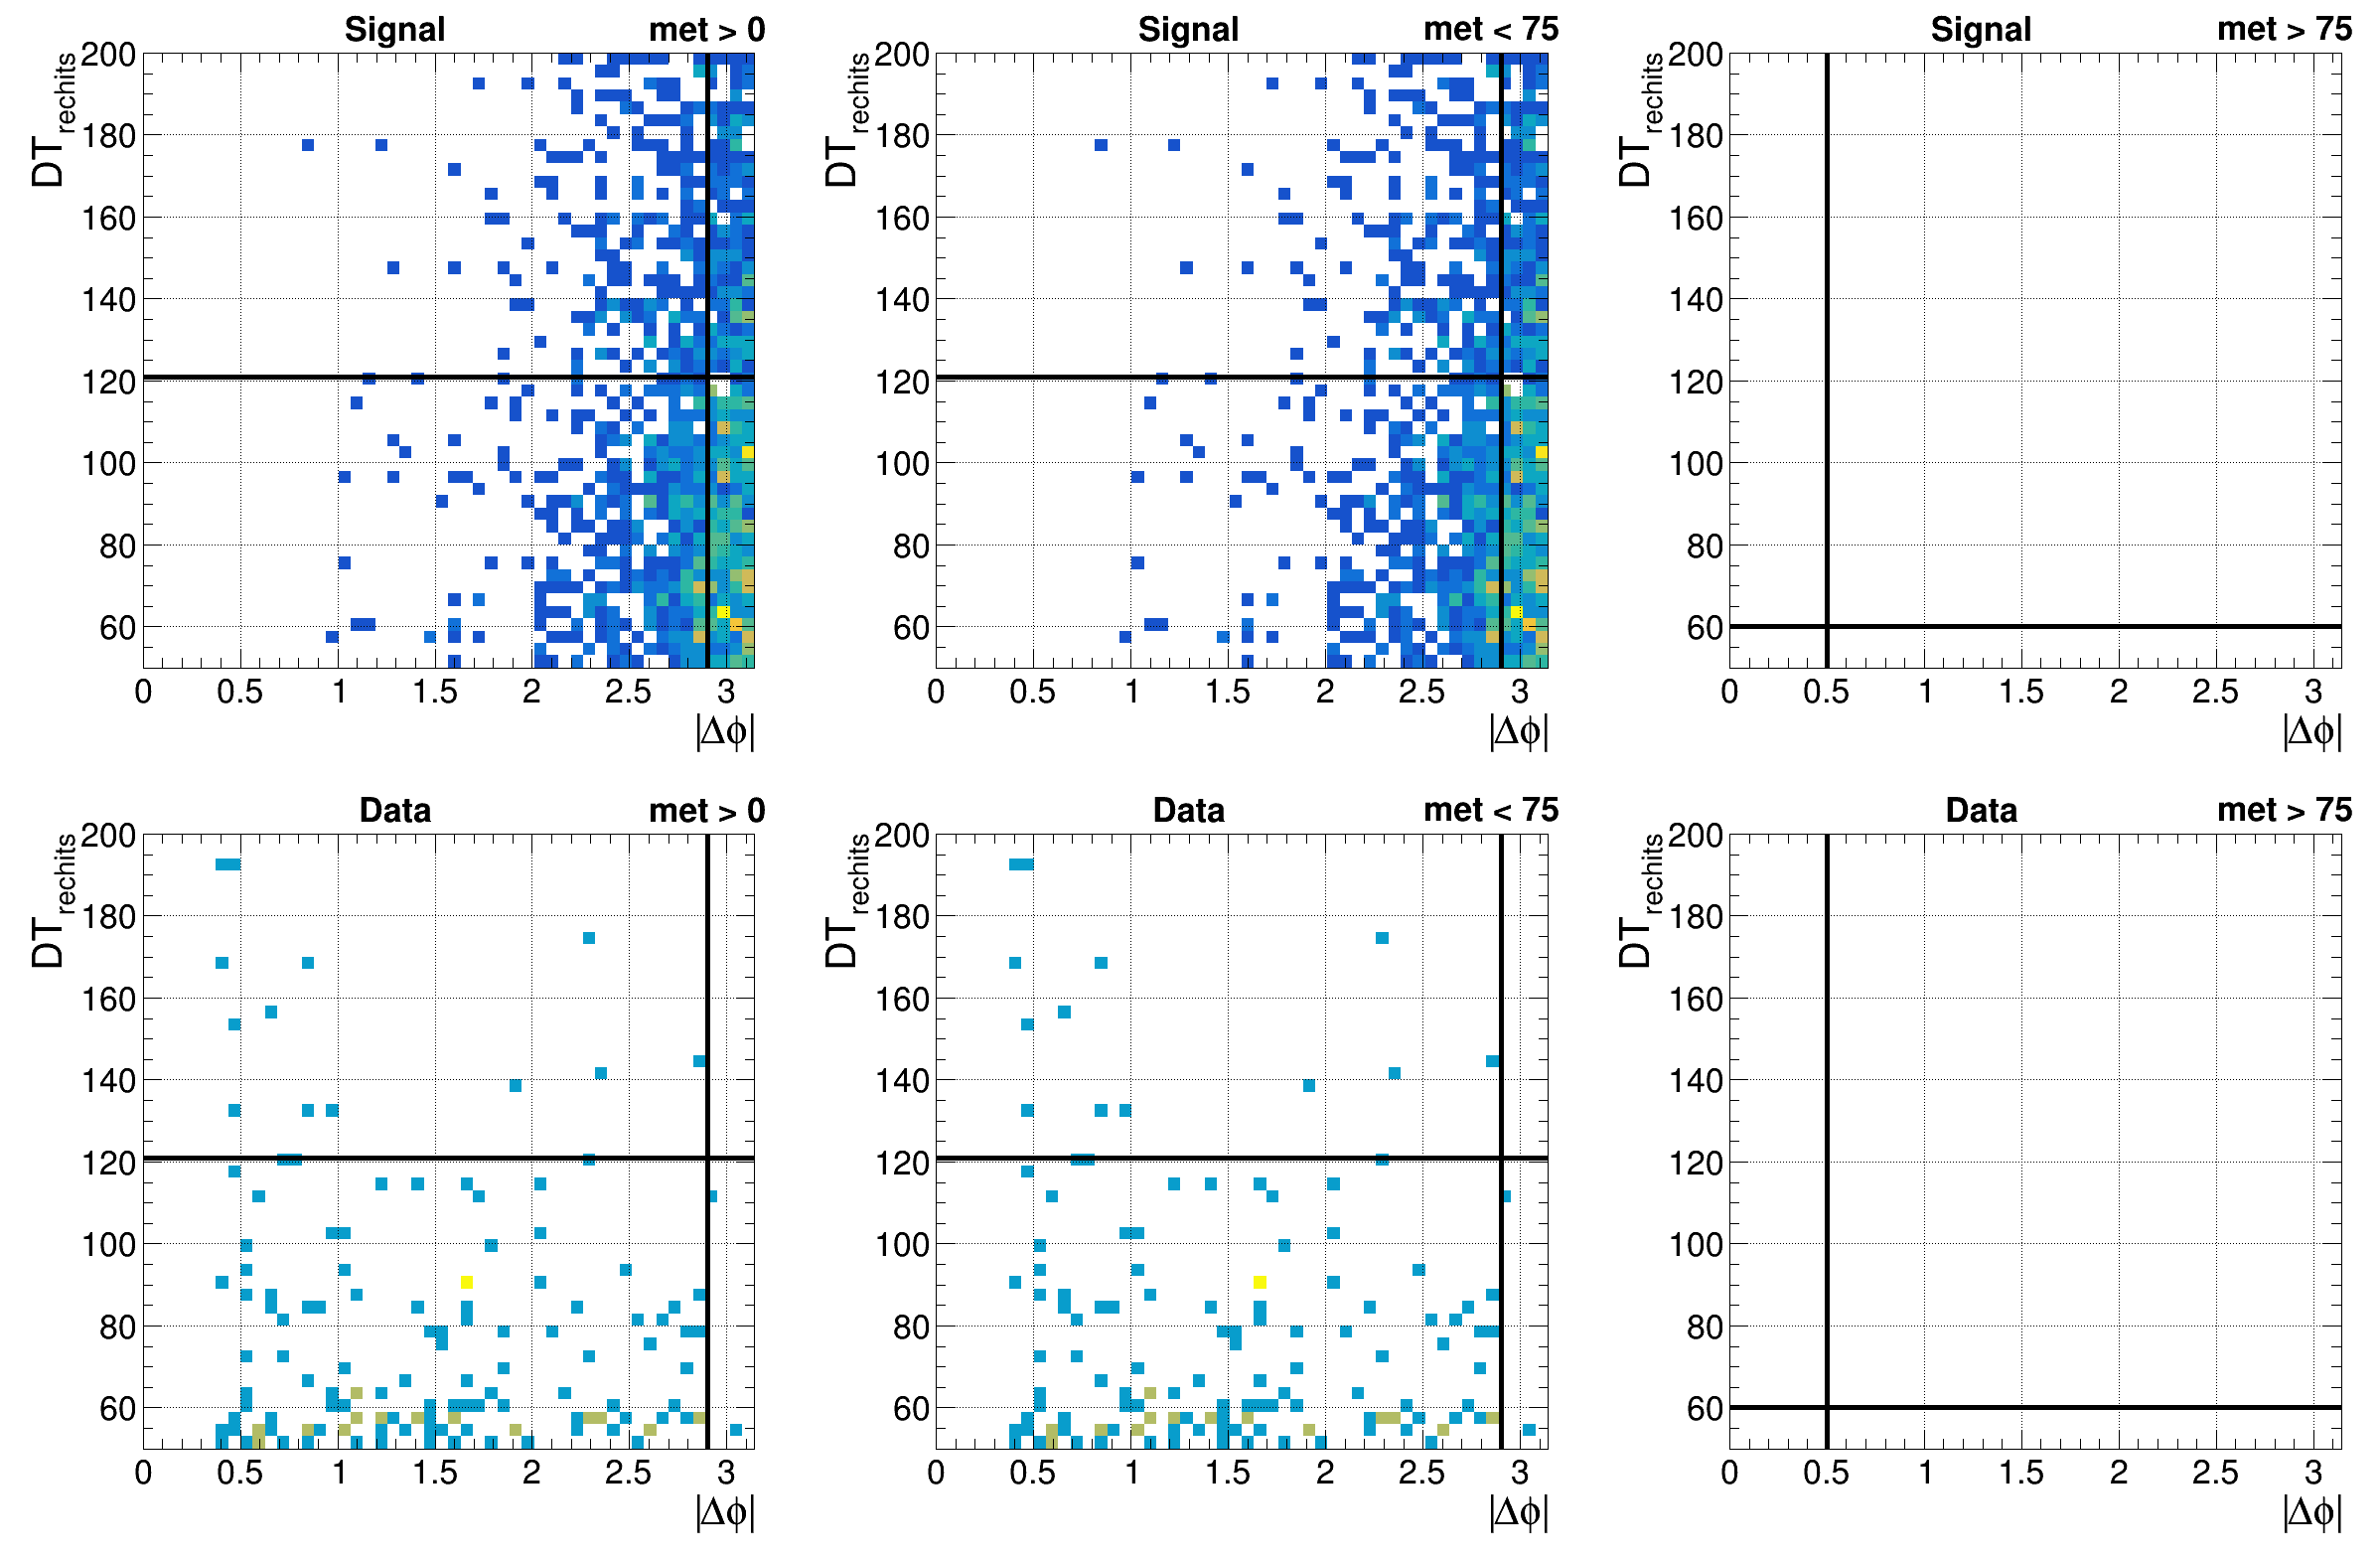

In [111]:
canvas = TCanvas('','',3*800,2*800)
canvas.Divide(3,2)
met = METS[0]
for i, ft in enumerate([('met >', 0), ('met <', met), ('met >', met)]):
    if ft[-1] in met_abcds:
        df, sz = met_abcds[ft[-1]][i][:2]
    else:
        df, sz = met_abcds[METS[0]][0][:2]
    ft = ' '.join([str(x) for x in ft])
    print(i,ft,df,sz)
    
    for j in range(2):
        canvas.cd(i+1 + 3*j).SetGrid()
        # canvas.cd(i+1).SetLogz()
        if j == 0:
            hh = rdfs['mc'].Filter(ft).Histo2D(('',ft+';|#Delta#phi|;DT_{rechits};',50,0,PI,50,50,200),'tag_dPhi','dtSize')#.GetValue()
        else:
            hh = rdfs['r3'].Filter(ft).Histo2D(('',ft+';|#Delta#phi|;DT_{rechits};',50,0,PI,50,50,200),'tag_dPhi','dtSize')#.GetValue()
        hh.Draw('col')
        lines = TLine(df, 50, df, 200), TLine(0, sz, PI, sz)
        for line in lines:
            line.SetLineWidth(5)
            line.Draw()
        latex = TLatex()
        latex.SetTextSize(0.05)
        latex.SetTextAlign(33)
        latex.DrawLatexNDC(1, 1, ft)
        latex.SetTextAlign(23)
        latex.DrawLatexNDC(0.5, 1, 'Data' if j else 'Signal')
        gc.extend([hh,lines, latex])
canvas.Draw()

# Limit Plots

In [150]:
import pickle

# Christinas Run2 limits
r2_limit_tree = []
with open(f'{DATA_DIR}/BB_15_DTCSC.csv', "r") as fin:
    for line in fin:
        if "ctau" in line:
            print(line.rstrip())
            continue
        r2_limit_tree.append([float(x) for x in line.split(",")])

r2_limit_tree = np.array(r2_limit_tree, dtype=np.float32)
r2_limit_tree = r2_limit_tree[np.argsort(r2_limit_tree[:,0])]

R2_LIMIT = r2_limit_tree[r2_limit_tree[:,0] == CTAU/1000, -1][0]
# My Run3 limits
with open(f'{DATA_DIR}/limits.pkl', 'rb') as f:
    limit_dict = pickle.load(f)


In [151]:

idxs1 = np.argsort(np.array(limit_dict['all']['ctau']))
idxs2 = np.argsort(np.array(limit_dict['all']['met'])[idxs1])

idxs1 = np.argsort(np.array(limit_dict['all']['met']))
idxs2 = np.argsort(np.array(limit_dict['all']['ctau'])[idxs1])

for k, v in limit_dict.items():
    for k2, v2 in v.items():
        limit_dict[k][k2] = np.array(v2)[idxs1][idxs2]

run2: met=75 limit=0.002162840450182557 (limit/R2 = 1.0)
all: met=75 limit=0.010884638992686092 (limit/R2 = 5.032566776604979)
low: met=75 limit=0.010884638992686092 (limit/R2 = 5.032566776604979)
high: met=75 limit=0.11596211219905478 (limit/R2 = 53.61565722023872)
comb: met=75 limit=0.010734151731786623 (limit/R2 = 4.962988245795289)


Error in <TCanvas::Range>: illegal world coordinates range: x1=75.000000, y1=-5.792683, x2=75.000000, y2=0.304878
Error in <TCanvas::RangeAxis>: illegal axis coordinates range: xmin=75.000000, ymin=-5.000000, xmax=75.000000, ymax=0.000000
Error in <TCanvas::Range>: illegal world coordinates range: x1=75.000000, y1=-5.792683, x2=75.000000, y2=0.304878
Error in <TCanvas::RangeAxis>: illegal axis coordinates range: xmin=75.000000, ymin=-5.000000, xmax=75.000000, ymax=0.000000


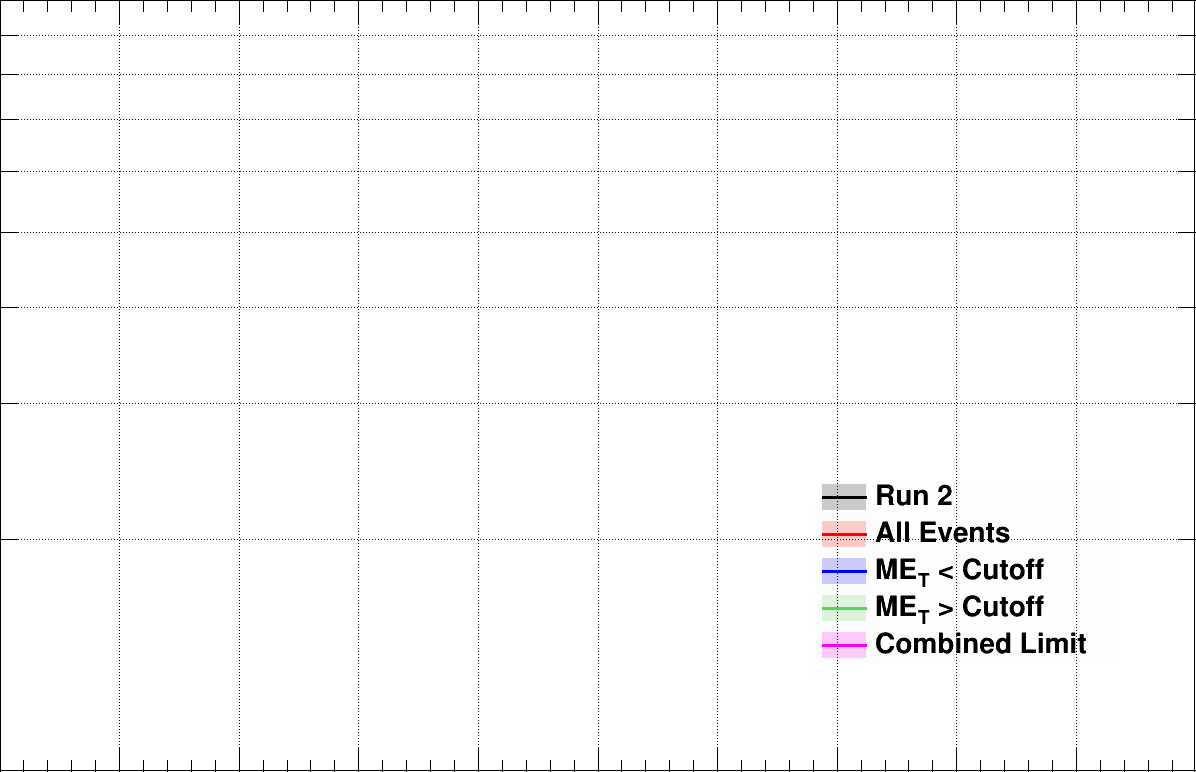

In [152]:
mets = limit_dict['all']['met']
ctaus = limit_dict['all']['ctau']

canvas = TCanvas('','',int(1.5*800),800)
canvas.SetLogy()
canvas.SetGrid()
canvas.SetRightMargin(0.04)

legend = TLegend(0.68, 0.14, 0.94, 0.38)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kWhite, 0)
legend.SetTextSize(0.04)
legend.SetMargin(0.2)

names = {'run2':'Run 2','all': 'All Events', 'high' : 'ME_{T} > Cutoff', 'low' : 'ME_{T} < Cutoff', 'comb' : 'Combined Limit'}
for il, name in enumerate(['run2', 'all', 'low', 'high', 'comb']):
    if name in limit_dict:
        limits = limit_dict[name]['limit'] # * 23/137
        limitELs = limit_dict[name]['2.5'] # * 23/137
        limitEHs = limit_dict[name]['97.5'] # * 23/137

        # _mets, _limits = mets, limits
        _mets, _limits = mets[ctaus == CTAU], limits[ctaus == CTAU]
        # _limitELs, _limitEHs = limitELs[ctaus == CTAU], limitEHs[ctaus == CTAU]
        _limitELs, _limitEHs = np.abs(_limits - limitELs[ctaus == CTAU]), np.abs(limitEHs[ctaus == CTAU] - _limits)
    else:
        _mets = mets[ctaus == CTAU]

        _limits = r2_limit_tree[r2_limit_tree[:,0] == CTAU/1000, -1] * np.ones_like(_mets)
        _limitELs = np.abs(r2_limit_tree[r2_limit_tree[:,0] == CTAU/1000, 1] * np.ones_like(_mets) - _limits)
        _limitEHs = np.abs(r2_limit_tree[r2_limit_tree[:,0] == CTAU/1000, -2] * np.ones_like(_mets) - _limits)

    idx = np.argmin(_limits)
    print(f'{name}: met={_mets[idx]} limit={_limits[idx]} (limit/R2 = {_limits[idx] / R2_LIMIT})')


    gr = TGraphAsymmErrors(len(_mets), _mets*1., _limits*1., _mets*0., _mets*0., _limitELs*1., _limitEHs*1.)
    gr.SetName(names[name])
    gr.GetXaxis().SetTitle('ME_{T} Categorization Boundary [GeV]')
    gr.GetYaxis().SetTitle('95% CL Upper Limit on Br(H#rightarrowSS)')
    gr.GetXaxis().SetLimits(np.min(_mets), np.max(_mets))
    gr.SetMinimum(1e-5)
    gr.SetMaximum(1)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[il])
    
    gr.SetMarkerSize(1)
    gr.SetMarkerColor(SCL[il])
    gr.SetMarkerStyle(rt.kFullCircle)

    gr.SetFillColorAlpha(SCL[il], 0.2)

    gr.Draw(('' if il else 'A ') + 'L3')
    legend.AddEntry(gr, gr.GetName(), 'LF')
    gc.append(gr)


legend.Draw()
canvas.Draw()


In [153]:
idx = np.argmin(limit_dict['comb']['limit'])
limit_dict['comb']['limit'][idx], limit_dict['comb']['met'][idx], limit_dict['comb']['ctau'][idx]

(0.010397724125895015, 75, 853)

run2 & 2.16e-03 (1.0) & 0.600 & 1.81e-03 (1.0) \\
all & 1.83e-03 (0.8) & 0.853 & 1.78e-03 (1.0) \\
low & 1.83e-03 (0.8) & 0.853 & 1.78e-03 (1.0) \\
high & 1.95e-02 (9.0) & 0.452 & 1.22e-02 (6.7) \\
comb & 1.80e-03 (0.8) & 0.853 & 1.75e-03 (1.0) \\


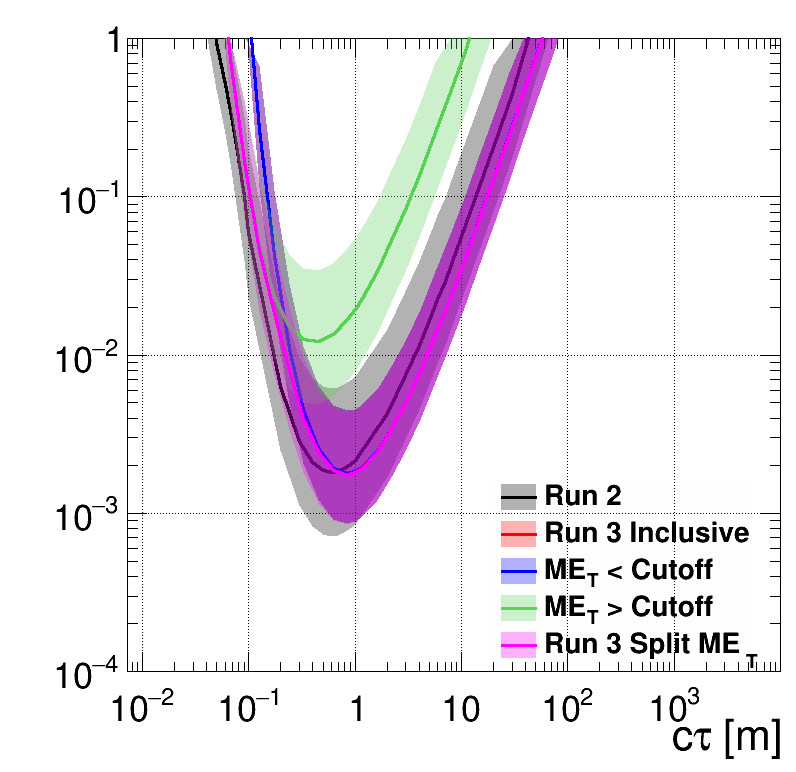

: 

In [156]:
mets = limit_dict['all']['met']
ctaus = limit_dict['all']['ctau']
# mets_plot = [25, 50, 75, 100, 150, 200]
mets_plot = [75]

canvas = TCanvas('','',800,800)
canvas.SetLogx()
canvas.SetLogy()
canvas.SetGrid()

legend = TLegend(0.62, 0.14, 0.94, 0.38)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kWhite, 0)
legend.SetTextSize(0.04)
legend.SetMargin(0.2)
ii = 0
names = {'run2':'Run 2','all': 'Run 3 Inclusive', 'high' : 'ME_{T} > Cutoff', 'low' : 'ME_{T} < Cutoff', 'comb' : 'Run 3 Split ME_{T}'}
for met in mets_plot:
    for il, name in enumerate(['run2', 'all', 'low', 'high', 'comb']):
        # if name not in ('run2','all','comb'):
        #     continue
        if name in limit_dict:
            limits = limit_dict[name]['limit'] * 23/137#*23/(60*2) # # 
            limitELs = limit_dict[name]['2.5'] * 23/137#*23/(60*2) # # 
            limitEHs = limit_dict[name]['97.5'] * 23/137#*23/(60*2) # # 

            # _ctaus, _limits = ctaus/1000, limits
            _ctaus, _limits = ctaus[mets == met]/1000, limits[mets == met]
            # _limitELs, _limitEHs = limitELs[mets == met]/1000, limitEHs[mets == met]
            _limitELs, _limitEHs = np.abs(_limits - limitELs[mets == met]), np.abs(limitEHs[mets == met] - _limits)
            
        else:
            _ctaus = r2_limit_tree[:, 0]
            _limits = r2_limit_tree[:, -1]
            _limitELs = np.abs(r2_limit_tree[:, 1] - _limits)
            _limitEHs = np.abs(r2_limit_tree[:, -2] - _limits)
        
        # gr = TGraph(len(ctaus), ctaus*1., limits*1.)
        # gr = TGraph(len(_ctaus), _ctaus*1., _limits*1.)
        gr = TGraphAsymmErrors(len(_ctaus), _ctaus*1., _limits*1., _ctaus*0., _ctaus*0., _limitELs*1., _limitEHs*1.)\
        
        lm1 = np.min(_limits[_ctaus==1])
        lmb = np.min(_limits)
        ctb = _ctaus[_limits == lmb][0]
        r21 = np.min(r2_limit_tree[r2_limit_tree[:,0]==1,-1])
        r2b = np.min(r2_limit_tree[:,-1])
    
        print(f'{name} & {lm1:.2e} ({lm1/r21:.1f}) & {ctb:.3f} & {lmb:.2e} ({lmb/r2b:.1f}) \\\\')
        gr.SetName(name)
        gr.SetName(names[name])
        gr.GetXaxis().SetTitle('c#tau [m]')

        gr.SetMinimum(1e-4)
        gr.SetMaximum(1)

        gr.SetLineWidth(3)
        gr.SetLineColor(SCL[il])
        
        gr.SetMarkerSize(1)
        gr.SetMarkerColor(SCL[il])
        gr.SetMarkerStyle(rt.kFullCircle)

        gr.SetFillColorAlpha(SCL[il], 0.3)

        gr.Draw(('' if ii else 'A ') + 'L3')
        ii += 1
        legend.AddEntry(gr, gr.GetName(), 'LF')
        gc.append(gr)


    legend.Draw()
canvas.Draw()


In [155]:
met_abcds

{75.0: array([[2.90000000e+00, 1.21000000e+02, 1.72769716e+02, 2.42240056e+02,
         2.83318171e+02, 2.01766032e+02, 1.24031008e-01, 1.00000000e+00,
         1.29000000e+02, 1.60000000e+01],
        [2.90000000e+00, 1.21000000e+02, 1.72769716e+02, 2.42240056e+02,
         2.83318171e+02, 2.01766032e+02, 1.24031008e-01, 1.00000000e+00,
         1.29000000e+02, 1.60000000e+01],
        [5.00000000e-01, 6.00000000e+01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00]]),
 150.0: array([[2.90000000e+00, 1.21000000e+02, 1.72769716e+02, 2.42240056e+02,
         2.83318171e+02, 2.01766032e+02, 1.24031008e-01, 1.00000000e+00,
         1.29000000e+02, 1.60000000e+01],
        [2.90000000e+00, 1.21000000e+02, 1.72769716e+02, 2.42240056e+02,
         2.83318171e+02, 2.01766032e+02, 1.24031008e-01, 1.00000000e+00,
         1.29000000e+02, 1.60000000e+01],
        [5.00000000e-01, 6.00000000e+01, 0.00